# Quantum Espresso Energy Volume Curve Workflow with aiida

## Define workflow with aiida

In [1]:
from python_workflow_definition.aiida import write_workflow_json
from python_workflow_definition.shared import get_dict, get_list

from aiida import load_profile, orm

load_profile()

workflow_json_filename = "aiida_qe.json"

In [2]:
from aiida_workgraph import task, WorkGraph

In [3]:
from quantum_espresso_workflow import generate_structures
from quantum_espresso_workflow import get_bulk_structure
from quantum_espresso_workflow import calculate_qe as _calculate_qe
from quantum_espresso_workflow import plot_energy_volume_curve

In [4]:
calculate_qe = task(outputs=["energy", "volume", "structure"])(_calculate_qe)

In [5]:
wg = WorkGraph("wg-qe")

## Prepare the inputs

In [6]:
element = orm.Str("Al")
a = orm.Float(4.05)
cubic = orm.Bool(True)
relax_workdir = orm.Str("mini")
pseudopotentials = orm.Dict({"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"})
kpts = orm.List([3, 3, 3])
calc_type_relax = orm.Str("vc-relax")
calc_type_scf = orm.Str("scf")
smearing = orm.Float(0.02)
strain_lst = orm.List([0.9, 0.95, 1.0, 1.05, 1.1])

## Actual tasks to construct the EOS workflow

In [7]:
get_bulk_structure_task = wg.add_task(
    get_bulk_structure,
    name="get_bulk_structure",
    element=element,
    a=a,
    cubic=cubic,
)

In [8]:
relax_prepare_input_dict_task = wg.add_task(
    get_dict,
    name="relax_get_dict",
    structure=get_bulk_structure_task.outputs.result,
    calculation=calc_type_relax,
    kpts=kpts,
    pseudopotentials=pseudopotentials,
    smearing=smearing,
)

relax_task = wg.add_task(
    calculate_qe,
    name="mini",
    input_dict=relax_prepare_input_dict_task.outputs.result,
    working_directory=relax_workdir,
)

In [9]:
generate_structures_task = wg.add_task(
    generate_structures,
    name="generate_structures",
    structure=relax_task.outputs.structure,
    strain_lst=strain_lst,
)

In [10]:
get_volumes_task = wg.add_task(get_list, name="get_volumes")

In [11]:
get_energies_task = wg.add_task(get_list, name="get_energies")

In [12]:
strain_dir_tasks, scf_qe_tasks, scf_get_dict_tasks = [], [], []

for i, strain in enumerate(strain_lst):

    structure_key = f"s_{i}"
    strain_dir = orm.Str(f"strain_{i}")
    generate_structures_task.add_output("workgraph.any", structure_key)

    scf_prepare_input_dict_task = wg.add_task(
        get_dict,
        name=f"get_dict_{i}",
        structure=generate_structures_task.outputs[structure_key],
        calculation=calc_type_scf,
        kpts=kpts,
        pseudopotentials=pseudopotentials,
        smearing=smearing,
    )

    scf_qe_task = wg.add_task(
        calculate_qe,
        name=f"qe_{i}",
        input_dict=scf_prepare_input_dict_task.outputs.result,
        working_directory=strain_dir,
    )

    # collect energy and volume
    get_energies_task.set({f"{i}": scf_qe_task.outputs.energy})
    get_volumes_task.set({f"{i}": scf_qe_task.outputs.volume})

In [13]:
plot_energy_volume_curve_task = wg.add_task(
    plot_energy_volume_curve,
    name="plot_energy_volume_curve",
    volume_lst=get_volumes_task.outputs.result,
    energy_lst=get_energies_task.outputs.result,
)

In [14]:
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'wg-qe',…

In [15]:
_ = write_workflow_json(wg=wg, file_name=workflow_json_filename)


In [16]:
!cat {workflow_json_filename}

{
  "nodes": {
    "0": "quantum_espresso_workflow.get_bulk_structure",
    "1": "python_workflow_definition.shared.get_dict",
    "2": "quantum_espresso_workflow.calculate_qe",
    "3": "quantum_espresso_workflow.generate_structures",
    "4": "python_workflow_definition.shared.get_list",
    "5": "python_workflow_definition.shared.get_list",
    "6": "python_workflow_definition.shared.get_dict",
    "7": "quantum_espresso_workflow.calculate_qe",
    "8": "python_workflow_definition.shared.get_dict",
    "9": "quantum_espresso_workflow.calculate_qe",
    "10": "python_workflow_definition.shared.get_dict",
    "11": "quantum_espresso_workflow.calculate_qe",
    "12": "python_workflow_definition.shared.get_dict",
    "13": "quantum_espresso_workflow.calculate_qe",
    "14": "python_workflow_definition.shared.get_dict",
    "15": "quantum_espresso_workflow.calculate_qe",
    "16": "quantum_espresso_workflow.plot_energy_volume_curve",
    "17": "Al",
    "18": 4.05,
    "19": true,
    "2

## Load Workflow with jobflow

In [17]:
from python_workflow_definition.jobflow import load_workflow_json

In [18]:
from jobflow.managers.local import run_locally

In [19]:
flow = load_workflow_json(file_name=workflow_json_filename)

2025-04-01 09:38:07,741 INFO Started executing jobs locally
2025-04-01 09:38:08,025 INFO Starting job - get_bulk_structure (4e19cf85-8556-41e9-8a66-7970c772779d)
2025-04-01 09:38:08,034 INFO Finished job - get_bulk_structure (4e19cf85-8556-41e9-8a66-7970c772779d)
2025-04-01 09:38:08,038 INFO Starting job - get_dict (332fbe1b-bfda-495a-9184-37aed1353865)
2025-04-01 09:38:08,046 INFO Finished job - get_dict (332fbe1b-bfda-495a-9184-37aed1353865)
2025-04-01 09:38:08,049 INFO Starting job - calculate_qe (9bf70cee-1283-468a-b4f4-fcc9f16129f7)


[thinkpad:375970] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-04-01 09:39:22,406 INFO Finished job - calculate_qe (9bf70cee-1283-468a-b4f4-fcc9f16129f7)
2025-04-01 09:39:22,408 INFO Starting job - generate_structures (87a28cb9-ef88-4537-a70d-9b34a37a726c)
2025-04-01 09:39:22,434 INFO Finished job - generate_structures (87a28cb9-ef88-4537-a70d-9b34a37a726c)
2025-04-01 09:39:22,437 INFO Starting job - get_dict (2a66ebc1-8ce6-417a-8b9b-77331dbf22ce)
2025-04-01 09:39:22,446 INFO Finished job - get_dict (2a66ebc1-8ce6-417a-8b9b-77331dbf22ce)
2025-04-01 09:39:22,449 INFO Starting job - get_dict (ddfa847d-a0b2-4cbe-b254-e5841880b426)
2025-04-01 09:39:22,455 INFO Finished job - get_dict (ddfa847d-a0b2-4cbe-b254-e5841880b426)
2025-04-01 09:39:22,458 INFO Starting job - get_dict (fe348067-207b-40ee-be46-eaa8b55a3047)
2025-04-01 09:39:22,469 INFO Finished job - get_dict (fe348067-207b-40ee-be46-eaa8b55a3047)
2025-04-01 09:39:22,472 INFO Starting job - get_dict (76a6883a-bac4-4fad-b1d9-fa0236ec3f8d)
2025-04-01 09:39:22,478 INFO Finished job - get_dict (

[thinkpad:377581] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-04-01 09:39:32,629 INFO Finished job - calculate_qe (a295270d-87db-41cc-aac2-88f7bd0b94d0)
2025-04-01 09:39:32,631 INFO Starting job - calculate_qe (9b7f6e91-aa74-48f0-8364-e5d344d8a274)


[thinkpad:377850] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-04-01 09:39:43,130 INFO Finished job - calculate_qe (9b7f6e91-aa74-48f0-8364-e5d344d8a274)
2025-04-01 09:39:43,133 INFO Starting job - calculate_qe (3427c80c-adb3-4cb5-a311-6a88af0d9aa7)


[thinkpad:378050] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-04-01 09:39:59,685 INFO Finished job - calculate_qe (3427c80c-adb3-4cb5-a311-6a88af0d9aa7)
2025-04-01 09:39:59,686 INFO Starting job - calculate_qe (a77c9b2d-6c97-443e-8484-aa140bf4f275)


[thinkpad:378429] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-04-01 09:40:19,201 INFO Finished job - calculate_qe (a77c9b2d-6c97-443e-8484-aa140bf4f275)
2025-04-01 09:40:19,203 INFO Starting job - calculate_qe (b8e75b04-9033-483f-a53f-3a77c8540186)


[thinkpad:378779] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-04-01 09:40:40,374 INFO Finished job - calculate_qe (b8e75b04-9033-483f-a53f-3a77c8540186)
2025-04-01 09:40:40,376 INFO Starting job - get_list (20193789-53c5-4a9d-95be-b4470eb3ac0f)
2025-04-01 09:40:40,392 INFO Finished job - get_list (20193789-53c5-4a9d-95be-b4470eb3ac0f)
2025-04-01 09:40:40,395 INFO Starting job - get_list (b389bc34-c79a-47ca-bf29-78aeab4fc8c4)
2025-04-01 09:40:40,408 INFO Finished job - get_list (b389bc34-c79a-47ca-bf29-78aeab4fc8c4)
2025-04-01 09:40:40,410 INFO Starting job - plot_energy_volume_curve (2a374153-788c-47c5-946e-e382992e4b38)
2025-04-01 09:40:40,745 INFO Finished job - plot_energy_volume_curve (2a374153-788c-47c5-946e-e382992e4b38)
2025-04-01 09:40:40,748 INFO Finished executing jobs locally


{'4e19cf85-8556-41e9-8a66-7970c772779d': {1: Response(output='{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.05, 0.0, 0.0], [0.0, 4.05, 0.0], [0.0, 0.0, 4.05]], "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]], "nsites": 4, "species": [{"name": "Al", "chemical_symbols": ["Al"], "concentration": [1.0], "mass": null, "original_name": null, "attached": null, "nattached": null}], "species_at_sites": ["Al", "Al", "Al", "Al"], "assemblies": null, "structure_features": []}', detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False, job_dir=PosixPath('/home/xing/repos/superstar54/python-workflow-definition'))},
 '332f

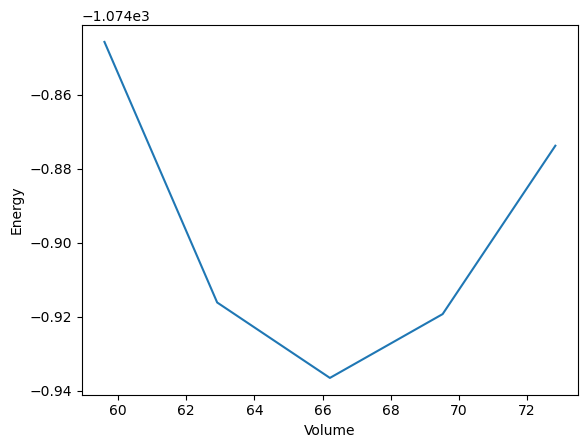

In [20]:
result = run_locally(flow)
result

## Load Workflow with pyiron_base

In [21]:
from pyiron_base import Project

In [22]:
from python_workflow_definition.pyiron_base import load_workflow_json

In [23]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

0it [00:00, ?it/s]

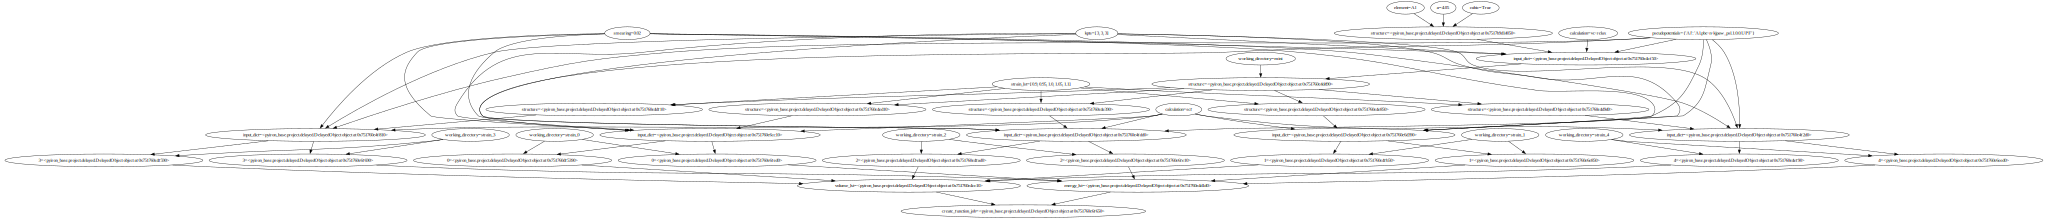

In [24]:
delayed_object = load_workflow_json(project=pr, file_name=workflow_json_filename)
delayed_object.draw()

The job get_bulk_structure_f1e730ed97e30e5439e855d2ac41396f was saved and received the ID: 1
The job get_dict_8c1e72002054a7529280a3e11ba005b5 was saved and received the ID: 2
The job calculate_qe_5e2d55d40f947e1c6791f89f7d93cd7c was saved and received the ID: 3


[thinkpad:379331] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


The job generate_structures_6042e2f1a150e0a8dc69909c3357e0e7 was saved and received the ID: 4
The job get_dict_773687310289049123463477639b2e74 was saved and received the ID: 5
The job calculate_qe_4d5f495146ebc0ce797711eb10c9a42c was saved and received the ID: 6


[thinkpad:381043] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


The job get_dict_29ff39cf860e1a7f4c8cc7d874b08a8d was saved and received the ID: 7
The job calculate_qe_cd318257eb4a8785b66151e9a85c382c was saved and received the ID: 8


[thinkpad:381257] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


The job get_dict_e3270a64b9a4153a91d4a851e538ad44 was saved and received the ID: 9
The job calculate_qe_b4bb4178ec80b7b49d05982d47a707f4 was saved and received the ID: 10


[thinkpad:381487] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


The job get_dict_b526e8a023fce1c4a4b8588b668f16e8 was saved and received the ID: 11
The job calculate_qe_71e06766387aec54f502114cdbbb1e85 was saved and received the ID: 12


[thinkpad:381880] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


The job get_dict_8b465dbd4ff6930762a35eac7d987f8e was saved and received the ID: 13
The job calculate_qe_716b050690854b48cae2bfb572cc5eb6 was saved and received the ID: 14


[thinkpad:382337] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


The job get_list_a28a868564f34fcd434fb31fd2b74340 was saved and received the ID: 15
The job get_list_d39a55ccd20cacf3dbeb1cfe70d08ed4 was saved and received the ID: 16
The job plot_energy_volume_curve_6f4c92d25a5f876513d595238396fafa was saved and received the ID: 17


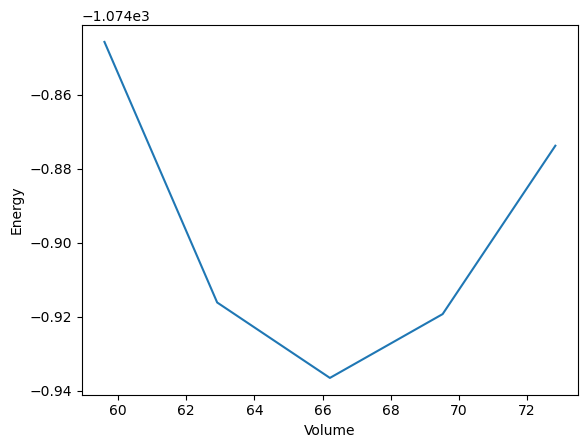

In [25]:
delayed_object.pull()